In [8]:
import os, sys, subprocess, fitsio, shutil
from collections import Counter

import numpy as np
from astropy.table import Table
from astropy.io import fits

import desimodel.io
import desimodel.focalplane
import desimodel.footprint
from desitarget.targetmask import desi_mask, obsconditions
import matplotlib.pyplot as plt
%matplotlib inline

**Learning goals**

In this notebook you will learn how to:

* Generate mock files from simulations to feed into fiberassign.
* Run fiberassign using the files generated above.
* Explore the outputs of fiberassign to estimate its efficiency.

In this example, for simplicity, only QSO targets are generated from the simulation.


This notebook reuses code by S. Bailey https://github.com/desihub/tutorials/blob/master/FiberAssign.ipynb

In [19]:
workdir = os.getenv('SCRATCH') + '/desi/test/fiberassign_mock'
os.makedirs(workdir, exist_ok=True)
os.chdir(workdir)
outdir = workdir + '/output'
os.makedirs(outdir, exist_ok=True)
shutil.copy(os.path.join(os.getenv('SCRATCH'), 'fiberassign_explore', 'input.yaml'), workdir)

In [24]:
# This is the content of the configuration file to be passed to select_mock_targets
!cat input.yaml

# mock target configuration file
targets:
    QSO: {
        target_type: QSO,
        mockfile: '{DESI_ROOT}/mocks/DarkSky/v1.0.1/qso_0_inpt.fits',
        format: gaussianfield,
        zmax_qso: 1.8,
        use_simqso: True,
        density: 120,
    }
    LYA: {
        target_type: QSO,
        mockfile: '{DESI_ROOT}/mocks/lya_forest/london/v4.0/master.fits',
        format: CoLoRe,
        nside_lya: 16,
        zmin_lya: 1.8,
        density: 50,
        use_simqso: True,
        balprob: 0.0,
        add_dla: True,
    }
    MWS_MAIN: {
        target_type: STAR,
        mockfile: '{DESI_ROOT}/mocks/mws/galaxia/alpha/v0.0.5/healpix',
        nside_galaxia: 8,
        format: galaxia,
    }
    WD: {
        target_type: WD,
        mockfile: '{DESI_ROOT}/mocks/mws/wd/v1.0.0/mock_wd.fits',
        format: mws_wd,
    }
    SKY: {
        target_type: SKY,
        mockfile: '{DESI_ROOT}/mocks/uniformsky/0.1/uniformsky-2048-0.1.fits',
        format: uniformsky,
    }


Some more files needed to run fiberassign

In [20]:
mtlfile = os.path.join(workdir, 'mtl.fits')
truthfile = os.path.join(workdir, 'truth.fits')
starfile = os.path.join(workdir, 'std.fits')
targetcutfile = os.path.join(workdir, 'targets.fits') 
skycutfile = os.path.join(workdir, 'sky.fits') 
tilefile = os.path.join(workdir, "tiles.fits")

In [21]:
# tile selection
program = "dark"

tiles = desimodel.io.load_tiles()
bright = tiles['PROGRAM']=='BRIGHT'
    
small = ((tiles['RA']>12) & (tiles['RA']<20) & (tiles['DEC']<1) & (tiles['DEC']>-1))

if program=="bright":
    Table(tiles[(bright)&(small)]).write(tilefile, overwrite=True)
else:
    Table(tiles[(~bright) & (small)]).write(tilefile, overwrite=True)

print("Wrote tiles to {}".format(tilefile))

Wrote tiles to /global/cscratch1/sd/forero/desi/test/fiberassign_mock/tiles.fits


In [22]:
!pwd
!ls

/global/cscratch1/sd/forero/desi/test/fiberassign_mock
input.yaml  output  tiles.fits


In [23]:
cmd = 'select_mock_targets --no-spectra --nproc 4 --nside 32 --seed 10'
cmd += ' -c ./input.yaml '
cmd += ' --output_dir ./ '
cmd += ' --tiles ./tiles.fits'
print(cmd)

select_mock_targets --no-spectra --nproc 4 --nside 16 --seed 10 -c ./input.yaml  --output_dir ./  --tiles ./tiles.fits


In [7]:
# To run target selection comment out these lines.
#print('RUNNING: '+cmd)
#err = subprocess.call(cmd.split())
#print(err)
#assert err == 0

In [25]:
cmd = 'join_mock_targets --mockdir ./'
print('RUNNING: '+cmd)
err = subprocess.call(cmd.split())
print(err)
assert err == 0

RUNNING: join_mock_targets --mockdir ./
0


Text(0,0.5,'DEC')

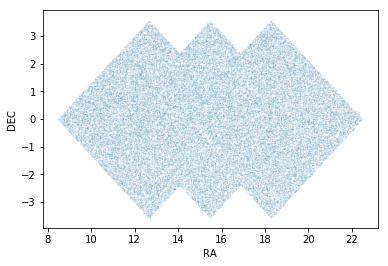

In [27]:
mtldata = Table.read('mtl.fits')
plt.scatter(mtldata['RA'], mtldata['DEC'],s=0.1, alpha=0.1)
plt.xlabel('RA')
plt.ylabel('DEC')

In [31]:
# Run fiberassign
cmd = 'fiberassign --mtl mtl.fits --stdstar standards-dark.fits --sky sky.fits'
cmd += ' --footprint ./tiles.fits'
cmd += ' --outdir ./output/'
cmd = cmd.format(outdir=outdir)

In [32]:
#- Cleanup old files if needed
for tileid in tiles['TILEID']:
    tilefile = '{}/tile_{:05d}.fits'.format(outdir, tileid)
    if os.path.exists(tilefile):
        os.remove(tilefile)
        
print('RUNNING: '+cmd)
err = subprocess.call(cmd.split())
print(err)
assert err == 0

RUNNING: fiberassign --mtl mtl.fits --stdstar standards-dark.fits --sky sky.fits --footprint ./tiles.fits --outdir ./output/
0


In [33]:
!ls output

tile_00543.fits  tile_06306.fits  tile_13111.fits  tile_23589.fits
tile_00544.fits  tile_07349.fits  tile_17827.fits  tile_24633.fits
tile_01587.fits  tile_12065.fits  tile_17829.fits  tile_24635.fits
tile_06305.fits  tile_12067.fits  tile_18873.fits


In [34]:
tiles = Table.read("tiles.fits")
targets = Table.read("mtl.fits")

Text(0,0.5,'DEC [deg]')

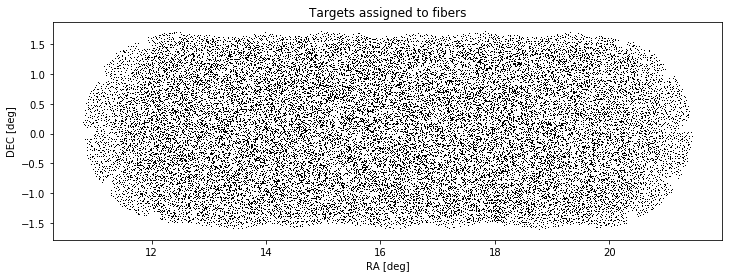

In [35]:
# Gather all outputs
assignments = list()
for tileid in tiles['TILEID']:
    tilefile = '{}/tile_{:05d}.fits'.format(outdir, tileid)
    assignments.append(Table.read(tilefile, 'FIBERASSIGN'))
    
assigned_targetids = np.concatenate([tmp['TARGETID'] for tmp in assignments])
isAssigned = np.in1d(targets['TARGETID'], assigned_targetids)

plt.figure(figsize=(12,4))
plt.plot(targets['RA'][isAssigned], targets['DEC'][isAssigned], 'k,')
plt.title('Targets assigned to fibers')
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')

Text(0,0.5,'DEC [deg]')

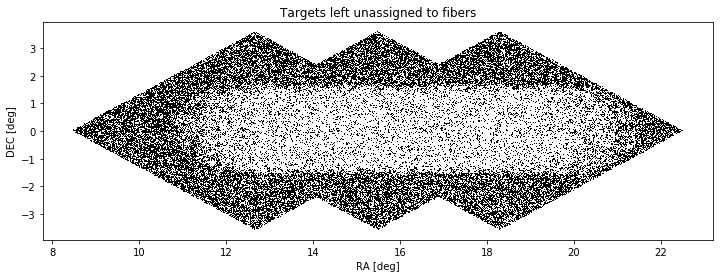

In [36]:
plt.figure(figsize=(12,4))
plt.plot(targets['RA'][~isAssigned], targets['DEC'][~isAssigned], 'k,')
plt.title('Targets left unassigned to fibers')
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')